In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pickle

In [2]:
# 1月から12月までのデータを読み込んで結合しdfに格納
df = pd.DataFrame()
for i in range(1, 13):
    df_tmp = pd.read_csv(f"../data_collection/data/2020-{i:02}.csv", encoding="utf8")
    df = pd.concat([df, df_tmp], ignore_index=True)
df.head()

,likes_count,title,body,created_date,created_time,tags,followers_count,organization,items_count
0,1.0,品質担保に本気で取り組んでみている話,株式会社オズビジョンの @terra_yucco です。2020/01 現在、オズビジョン ...,2020-01-31,23:59:59,"['仕様', '品質管理', '品質', 'QCD']",43.0,OZvision Inc.,97.0
1,5.0,【Unity】Screen.safeAreaとiOSステータスバーの罠（？）,# Unityで取得できる Screen.safeAreaには罠（？）がある罠に遭遇したのは...,2020-01-31,23:56:36,"['iOS', 'Unity', 'SafeArea']",2.0,NaN,7.0
2,3.0,徹底攻略！“SATySFiのロゴ”の出し方,**SATySFiのロゴ**といえば、もちろんコレですね。![image-1a.png](h...,2020-01-31,23:54:15,['SATySFi'],157.0,NaN,65.0
3,0.0,【KPI】家系図テーブルの操作 1【oracle】,某炎の紋章の家系図見てて、TRPGなどに使えるかなと思って家系図テーブルの運用を考える。階層...,2020-01-31,23:50:44,['oracle'],1.0,NaN,10.0
4,0.0,プログラミング・フォロを組み立てる,#プログラミング・フォロmicro:bitを内蔵して６本足で自律して歩き回ることの出来る [...,2020-01-31,23:45:47,"['RaspberryPi', 'microbit']",3.0,NaN,11.0


In [3]:
# dfの各カラムのデータ型を確認
df.dtypes

likes_count        float64
title               object
body                object
created_date        object
created_time        object
tags                object
followers_count    float64
organization        object
items_count        float64
dtype: object

In [4]:
# dfの各カラムの欠損値の数を確認
df.isnull().sum()

likes_count             1
title                   0
body                    1
created_date            1
created_time            1
tags                    1
followers_count         2
organization       110525
items_count             2
dtype: int64

In [5]:
# organizationに値が入っていればTrue、欠損していればFalseに置き換える
df["organization"] = df["organization"].notnull()
df.head()

,likes_count,title,body,created_date,created_time,tags,followers_count,organization,items_count
0,1.0,品質担保に本気で取り組んでみている話,株式会社オズビジョンの @terra_yucco です。2020/01 現在、オズビジョン ...,2020-01-31,23:59:59,"['仕様', '品質管理', '品質', 'QCD']",43.0,True,97.0
1,5.0,【Unity】Screen.safeAreaとiOSステータスバーの罠（？）,# Unityで取得できる Screen.safeAreaには罠（？）がある罠に遭遇したのは...,2020-01-31,23:56:36,"['iOS', 'Unity', 'SafeArea']",2.0,False,7.0
2,3.0,徹底攻略！“SATySFiのロゴ”の出し方,**SATySFiのロゴ**といえば、もちろんコレですね。![image-1a.png](h...,2020-01-31,23:54:15,['SATySFi'],157.0,False,65.0
3,0.0,【KPI】家系図テーブルの操作 1【oracle】,某炎の紋章の家系図見てて、TRPGなどに使えるかなと思って家系図テーブルの運用を考える。階層...,2020-01-31,23:50:44,['oracle'],1.0,False,10.0
4,0.0,プログラミング・フォロを組み立てる,#プログラミング・フォロmicro:bitを内蔵して６本足で自律して歩き回ることの出来る [...,2020-01-31,23:45:47,"['RaspberryPi', 'microbit']",3.0,False,11.0


In [6]:
# 欠損値を含む行を削除
df = df.dropna()
# indexを振り直す
df = df.reset_index(drop=True)

In [7]:
# likes_countの値が1000以上の行を抽出
df[df["likes_count"] >= 1000].head()

,likes_count,title,body,created_date,created_time,tags,followers_count,organization,items_count
749,1386.0,Vue開発者のためのVue.jsベストプラクティス集15選,# はじめに**みなさん、Vue使ってますかー！**・・・・・・・（へんじがない。ただのしか...,2020-01-29,23:00:56,"['JavaScript', 'Vue.js', 'Nuxt']",131.0,False,15.0
1008,1523.0,Vue.jsで作成された、ちょっと面白くて役立ちそうなサービス,## [こちらに移行しました。(2020/05/16)](https://tech-blog...,2020-01-29,08:43:49,"['JavaScript', 'Bootstrap', 'ツール', 'Vue.js', '...",35.0,False,19.0
1459,1024.0,FFT（高速フーリエ変換）を完全に理解する話,"FFT(Fast Fourier Transform),高速フーリエ変換についての記事です。...",2020-01-27,22:00:06,"['アルゴリズム', 'math', 'AtCoder', '競技プログラミング']",163.0,False,28.0
3500,1062.0,2020年現在 Web系企業で採用されてる技術についてまとめてみた,# はじめに2020年も始まりましたね！タイトル通りですが、2020年現在スタートアップや大...,2020-01-22,10:43:23,"['初心者', 'ツール', 'まとめ', '初心者向け', 'プログラミング言語']",24.0,False,27.0
3868,4834.0,良いコードの書き方,# 概要チームによる継続的開発を前提としたコーディングのガイドライン。特定の言語を対象とした...,2020-01-21,10:50:39,"['Java', 'プログラミング', 'コーディング規約', 'チーム開発', 'Swift']",128.0,True,29.0


In [8]:
# likes_countの値が1000以上なら1000に置き換える
df.loc[df["likes_count"] >= 1000, "likes_count"] = 1000
df[df["likes_count"] >= 1000].head()

,likes_count,title,body,created_date,created_time,tags,followers_count,organization,items_count
749,1000.0,Vue開発者のためのVue.jsベストプラクティス集15選,# はじめに**みなさん、Vue使ってますかー！**・・・・・・・（へんじがない。ただのしか...,2020-01-29,23:00:56,"['JavaScript', 'Vue.js', 'Nuxt']",131.0,False,15.0
1008,1000.0,Vue.jsで作成された、ちょっと面白くて役立ちそうなサービス,## [こちらに移行しました。(2020/05/16)](https://tech-blog...,2020-01-29,08:43:49,"['JavaScript', 'Bootstrap', 'ツール', 'Vue.js', '...",35.0,False,19.0
1459,1000.0,FFT（高速フーリエ変換）を完全に理解する話,"FFT(Fast Fourier Transform),高速フーリエ変換についての記事です。...",2020-01-27,22:00:06,"['アルゴリズム', 'math', 'AtCoder', '競技プログラミング']",163.0,False,28.0
3500,1000.0,2020年現在 Web系企業で採用されてる技術についてまとめてみた,# はじめに2020年も始まりましたね！タイトル通りですが、2020年現在スタートアップや大...,2020-01-22,10:43:23,"['初心者', 'ツール', 'まとめ', '初心者向け', 'プログラミング言語']",24.0,False,27.0
3868,1000.0,良いコードの書き方,# 概要チームによる継続的開発を前提としたコーディングのガイドライン。特定の言語を対象とした...,2020-01-21,10:50:39,"['Java', 'プログラミング', 'コーディング規約', 'チーム開発', 'Swift']",128.0,True,29.0


# 変更ここから
全てのデータを結合するのをやめる

* title	-> TF-IDF
* body -> TF-IDF
* created_date -> 何日前に作成されたかに変更
* created_time -> 何時に作成されたかに変更
* tags -> タグの数とタグのTF-IDF
* followers_count
* organization -> 所属しているかどうか
* items_count

In [9]:
# created_dateを今日から何日前に投稿されたかを表す数値に変換
df["created_date"] = pd.to_datetime(df["created_date"])
df["created_days_ago"] = (pd.to_datetime("today") - df["created_date"]).dt.days
df["created_month"] = df["created_date"].dt.month
df = df.drop("created_date", axis=1)
# created_timeを何時に投稿されたかに変換
df["created_time"] = df["created_time"].str[:2].astype(int)
df.head()

,likes_count,title,body,created_time,tags,followers_count,organization,items_count,created_days_ago,created_month
0,1.0,品質担保に本気で取り組んでみている話,株式会社オズビジョンの @terra_yucco です。2020/01 現在、オズビジョン ...,23,"['仕様', '品質管理', '品質', 'QCD']",43.0,True,97.0,1044,1
1,5.0,【Unity】Screen.safeAreaとiOSステータスバーの罠（？）,# Unityで取得できる Screen.safeAreaには罠（？）がある罠に遭遇したのは...,23,"['iOS', 'Unity', 'SafeArea']",2.0,False,7.0,1044,1
2,3.0,徹底攻略！“SATySFiのロゴ”の出し方,**SATySFiのロゴ**といえば、もちろんコレですね。![image-1a.png](h...,23,['SATySFi'],157.0,False,65.0,1044,1
3,0.0,【KPI】家系図テーブルの操作 1【oracle】,某炎の紋章の家系図見てて、TRPGなどに使えるかなと思って家系図テーブルの運用を考える。階層...,23,['oracle'],1.0,False,10.0,1044,1
4,0.0,プログラミング・フォロを組み立てる,#プログラミング・フォロmicro:bitを内蔵して６本足で自律して歩き回ることの出来る [...,23,"['RaspberryPi', 'microbit']",3.0,False,11.0,1044,1


In [10]:
# この状態で一旦保存
# df.to_csv("data/df_base.csv", index=False)

In [11]:
# 文の情報をTF-IDFでベクトル化してからSVDで10次元に削減する関数
def vectorize_text(text, n_components=10):
    tfidf = TfidfVectorizer()
    df_tfidf = tfidf.fit_transform(df[text])
    pickle.dump(tfidf, open(f"output/tfidf_{text}.pkl", "wb"))
    svd = TruncatedSVD(n_components=n_components)
    df_svd = svd.fit_transform(df_tfidf)
    pickle.dump(tfidf, open(f"output/svd_{text}.pkl", "wb"))
    df_ret = pd.DataFrame(df_svd, columns=[f"{text}_{i}" for i in range(n_components)])
    return df_ret

In [12]:
# 指定のカラムをベクトル化して結合
for col, n_components in [("title", 20), ("body", 20), ("tags", 20)]:
    df_vec = vectorize_text(col, n_components)
    # ベクトル化したカラムを結合
    df = pd.concat([df, df_vec], axis=1)
    # 欠損値を含む行を削除
    df = df.dropna()
    # 元のカラムを削除
    df = df.drop(col, axis=1)
df.head()

,likes_count,created_time,followers_count,organization,items_count,created_days_ago,created_month,title_0,title_1,title_2,...,tags_10,tags_11,tags_12,tags_13,tags_14,tags_15,tags_16,tags_17,tags_18,tags_19
0,1.0,23,43.0,True,97.0,1044,1,-4.704633e-15,-3.848896e-16,-1.671601e-14,...,0.000004,-9.444589e-07,-7.986393e-08,3.400716e-06,0.000004,0.000005,0.000005,-0.000001,0.000006,0.000007
1,5.0,23,2.0,False,7.0,1044,1,5.389205e-04,8.832025e-04,8.339673e-04,...,0.112110,1.484374e-01,3.805801e-03,-2.260616e-04,-0.002617,-0.001735,0.334619,0.019939,-0.132934,0.011099
2,3.0,23,157.0,False,65.0,1044,1,1.945344e-06,1.072124e-06,3.616851e-06,...,0.000002,-3.301775e-07,3.313865e-06,-3.649263e-07,0.000004,0.000010,0.000007,-0.000004,0.000007,-0.000005
3,0.0,23,1.0,False,10.0,1044,1,1.194472e-03,1.422370e-03,2.890677e-03,...,0.001258,-1.617687e-03,5.097725e-03,5.723901e-05,-0.000277,-0.000646,-0.000525,-0.002851,0.002219,0.019574
4,0.0,23,3.0,False,11.0,1044,1,1.084439e-04,1.391798e-04,1.771211e-04,...,0.000749,8.380299e-04,6.746553e-04,-2.148812e-03,0.003819,0.002895,0.005745,-0.001784,0.002193,0.002581


In [13]:
# trainとtestに分割する(likes_countを目的変数とする)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=0)
train_y = train["likes_count"]
train_X = train.drop(["likes_count"], axis=1)
test_y = test["likes_count"]
test_X = test.drop(["likes_count"], axis=1)

In [14]:
# LGBMでモデルの学習
import lightgbm as lgb
model = lgb.LGBMRegressor()
model.fit(train_X, train_y)
pickle.dump(model, open("output/model.pkl", "wb"))

# テストデータの予測
y_pred = model.predict(test_X)

In [15]:
# 平均絶対誤差を計算
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_y, y_pred)

9.630939711141203

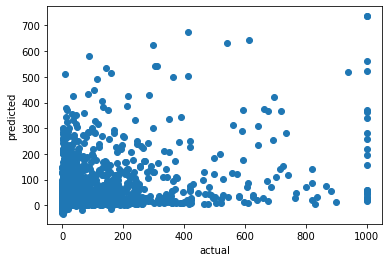

In [16]:
# 散布図を描画
plt.scatter(test_y, y_pred)
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

In [17]:
# y_predの値が負なら0に置き換える
y_pred[y_pred < 0] = 0
# 平均絶対誤差を計算
mean_absolute_error(test_y, y_pred)

9.6147873316483

# 結論
* 全て結合するのはよくない
* 圧縮率を下げてもあまり変わらない

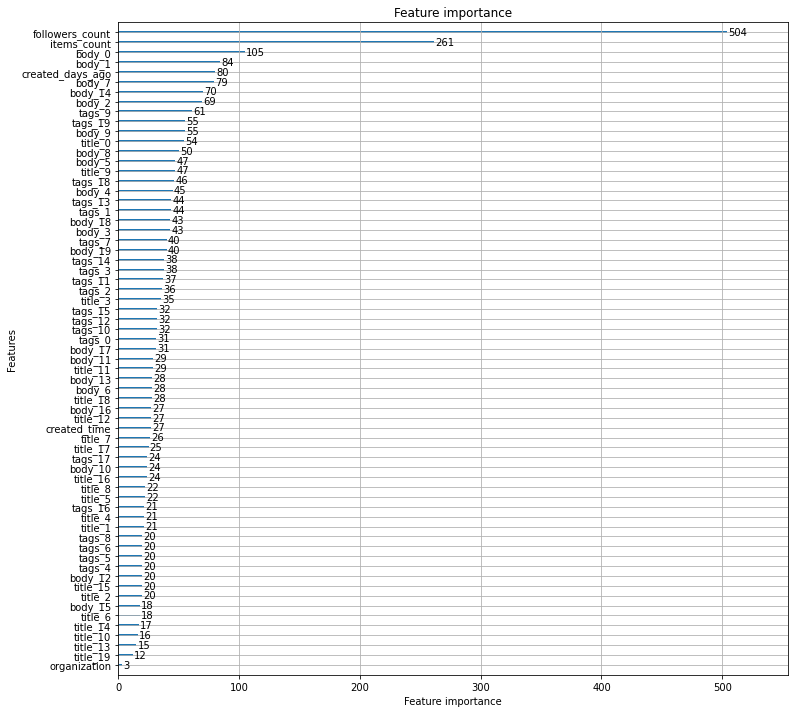

In [18]:
# 特徴量の重要度を可視化
lgb.plot_importance(model, figsize=(12, 12))
plt.show()